# Library

In [113]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers

from gensim.models import Word2Vec

import matplotlib.pyplot as plt

import mlflow
import mlflow.keras

from sklearn.metrics import accuracy_score

# Preprocessing

In [114]:
fnd_data_0=pd.read_csv('https://fnd-jedha-project.s3.eu-west-3.amazonaws.com/3_WELFake_Embedding_workbase.csv')
fnd_data_0.head()

,label,message,message_clean
0,0,LAW ENFORCEMENT ON HIGH ALERT Following Threat...,law enforcement high alert follow threat cop w...
1,0,UNBELIEVABLE! OBAMA’S ATTORNEY GENERAL SAYS MO...,unbelievable obamas attorney general charlotte...
2,1,"Bobby Jindal, raised Hindu, uses story of Chri...",bobby jindal raise hindu use story christian c...
3,0,SATAN 2: Russia unvelis an image of its terrif...,satan 2 russia unvelis image terrifying new su...
4,0,About Time! Christian Group Sues Amazon and SP...,time christian group sue amazon splc designati...


In [115]:
fnd_data=fnd_data_0.sample(10000)

In [116]:
sentences = fnd_data['message_clean'].tolist()
labels = fnd_data['label'].tolist()

In [117]:
# Entraîner le modèle Word2Vec
embedding_dim = 8  # Dimension des vecteurs Word2Vec
word2vec_model = Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)


In [118]:
# Tokenizer Keras
tokenizer = Tokenizer()
tokenizer.fit_on_texts([" ".join(sentence) for sentence in sentences])
vocab_size = len(tokenizer.word_index) + 1

In [119]:
# Créer une matrice d'embedding
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

In [120]:
# Définir la longueur maximale des séquences
max_length = max(len(sentence) for sentence in sentences)

# Modelling

In [121]:
# Préparer les données d'entraînement
X_train = tokenizer.texts_to_sequences([" ".join(sentence) for sentence in sentences])
X_train = pad_sequences(X_train, maxlen=100, padding='post')
y_train = np.array(labels)

In [122]:

# Définir le modèle Keras
base_model = tf.keras.Sequential([
    # Couche d'Input Word Embedding avec la matrice d'embedding pré-entraînée
    tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=True, name="embedding"),
    # Couche LSTM
    tf.keras.layers.LSTM(32, return_sequences=True,kernel_regularizer=regularizers.l2(0.01)),
    # Global Average Pooling
    tf.keras.layers.GlobalAveragePooling1D(),
    # Couche Dense classique
    tf.keras.layers.Dense(64, activation='relu'),
    #Drop out pour prévenir de l'over-fitting
    tf.keras.layers.Dropout(0.5), 
    # Couche de sortie
    tf.keras.layers.Dense(1, activation="sigmoid")
])

# Compilation du modèle
base_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=[
        tf.keras.metrics.BinaryAccuracy(),
        #tf.keras.metrics.Precision(),
        #tf.keras.metrics.Recall(),
        #tf.keras.metrics.AUC()
    ]
)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [123]:
# Entraînement du modèle
history=base_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

2025/01/28 15:48:08 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID 'b60f05d3f2b54eaa8a332fa5d31da7d1', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current keras workflow


2025/01/28 15:48:13 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Failed to upload /tmp/tmpwstdi3xd/model_summary.txt to fnd-jedha-project/9/b60f05d3f2b54eaa8a332fa5d31da7d1/artifacts/model_summary.txt: An error occurred (AccessDenied) when calling the PutObject operation: Access Denied


Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - binary_accuracy: 0.5673 - loss: 0.7376 - val_binary_accuracy: 0.5840 - val_loss: 0.6773
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - binary_accuracy: 0.5706 - loss: 0.6824 - val_binary_accuracy: 0.6505 - val_loss: 0.6465
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - binary_accuracy: 0.6341 - loss: 0.6472 - val_binary_accuracy: 0.6955 - val_loss: 0.5934
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - binary_accuracy: 0.7036 - loss: 0.5892 - val_binary_accuracy: 0.7150 - val_loss: 0.5656
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - binary_accuracy: 0.7047 - loss: 0.5739 - val_binary_accuracy: 0.7210 - val_loss: 0.5656
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - binary_accuracy: 0.7135 - loss: 0.5639 - val_binary_accuracy: 0.7170 - val_loss: 0.5570
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - binary_accuracy: 0.7120 - loss: 0.5581 - val_binary_accuracy: 0.7160 - val_loss:

2025/01/28 15:53:01 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: All input schema' first dimension should be -1, which represents the dynamic batch dimension.


## Check Metrics

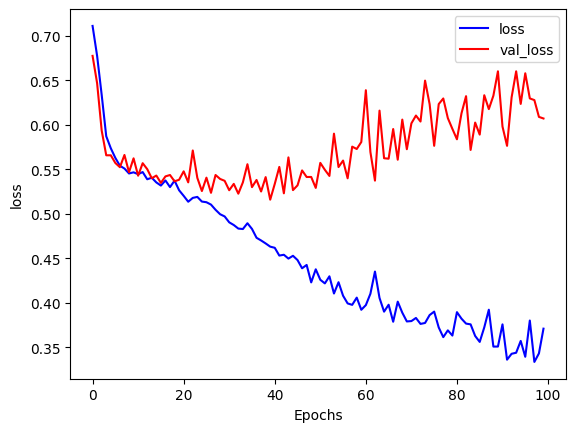

In [124]:
plt.plot(history.history['loss'], color='b', label='loss')
plt.plot(history.history['val_loss'], color='r', label='val_loss')
plt.ylabel('loss')
plt.xlabel('Epochs')
plt.legend()
plt.show()

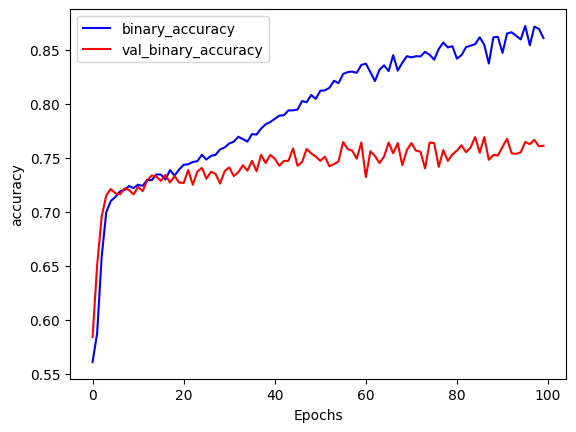

In [125]:
plt.plot(history.history['binary_accuracy'], color='b', label='binary_accuracy')
plt.plot(history.history['val_binary_accuracy'], color='r', label='val_binary_accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epochs')
plt.legend()
plt.show()

# ML Flow - Log Model

In [127]:
# Configuration de MLflow
EXPERIMENT_NAME = "Fake News Detector - Word2vec Model"
mlflow.set_tracking_uri('https://fmendes13-fake-news-detector.hf.space')
mlflow.set_experiment(EXPERIMENT_NAME)

experiment = mlflow.get_experiment_by_name(EXPERIMENT_NAME)

# Activer l'autologging pour Keras
mlflow.keras.autolog()

# Démarrer une nouvelle run MLflow
with mlflow.start_run(experiment_id=experiment.experiment_id):
    # Entraînement du modèle Word2Vec
    word2vec_model = Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)
    
    # Création de la matrice d'embedding
    embedding_matrix = np.zeros((vocab_size, embedding_dim))
    for word, i in tokenizer.word_index.items():
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]

    # Construction du modèle Keras
    base_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], input_length=max_length, trainable=True, name="embedding"),
    tf.keras.layers.LSTM(32, return_sequences=True,kernel_regularizer=regularizers.l2(0.01)),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation="sigmoid")
    ])

    # Compilation du modèle
    base_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.005),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy']
    )

    # Entraînement du modèle
    history = base_model.fit(X_train, y_train, epochs=100, batch_size=64, validation_split=0.2)

    # Évaluation du modèle
    y_pred = (base_model.predict(X_train) > 0.5).astype("int32")
    accuracy = accuracy_score(y_train, y_pred)

    # Affichage des résultats
    print("Modèle Word2Vec + Keras")
    print(f"Accuracy sur l'ensemble d'entraînement : {accuracy}")

2025/01/28 15:56:57 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during autologging: Failed to upload /tmp/tmp5cme_ql5/model_summary.txt to fnd-jedha-project/9/57ca9f738b274e18b081373ece5f7dfc/artifacts/model_summary.txt: An error occurred (AccessDenied) when calling the PutObject operation: Access Denied


Epoch 1/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - accuracy: 0.5286 - loss: 0.7397 - val_accuracy: 0.5835 - val_loss: 0.6752
Epoch 2/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - accuracy: 0.5707 - loss: 0.6836 - val_accuracy: 0.6410 - val_loss: 0.6483
Epoch 3/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.6371 - loss: 0.6568 - val_accuracy: 0.6790 - val_loss: 0.6188
Epoch 4/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6764 - loss: 0.6291 - val_accuracy: 0.7100 - val_loss: 0.5901
Epoch 5/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.6809 - loss: 0.6020 - val_accuracy: 0.7055 - val_loss: 0.5957
Epoch 6/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.6976 - loss: 0.5802 - val_accuracy: 0.6970 - val_loss: 0.5971
Epoch 7/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.7064 - loss: 0.5662 - val_accuracy: 0.7125 - val_loss: 0.5675
Epoch 8/100
125/125 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step - accuracy: 0.7034 - loss: 0.5639 - 

2025/01/28 16:01:36 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during keras autologging: All input schema' first dimension should be -1, which represents the dynamic batch dimension.


313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
Modèle Word2Vec + Keras
Accuracy sur l'ensemble d'entraînement : 0.8348
🏃 View run efficient-dove-140 at: https://fmendes13-fake-news-detector.hf.space/#/experiments/9/runs/57ca9f738b274e18b081373ece5f7dfc
🧪 View experiment at: https://fmendes13-fake-news-detector.hf.space/#/experiments/9
